In [1]:
from sklearn.datasets import load_iris
import pandas as pd

content = load_iris()

data = pd.DataFrame(content.data, columns=[f"x{i+1}" for i in range(content.data.shape[1])])
data["y"] = (content.target == 1).astype(int)
print(data.head())

    x1   x2   x3   x4  y
0  5.1  3.5  1.4  0.2  0
1  4.9  3.0  1.4  0.2  0
2  4.7  3.2  1.3  0.2  0
3  4.6  3.1  1.5  0.2  0
4  5.0  3.6  1.4  0.2  0


In [2]:
from estyp.linear_model.stepwise import forward_selection, both_selection
from estyp.linear_model import LogisticRegression

formula = "y ~ x1 + x2 + x3 + x4"

ff1 = forward_selection(
    y       = "y",
    data    = data,
    model   = LogisticRegression,
    verbose = False,
)
ff2 = both_selection(
    formula = formula,
    data    = data,
    model   = LogisticRegression,
    verbose = False
)
print("- Forward result:", ff1)
print("- Both result   :", ff2)

Looking for help? Visit the ESTYP documentation: https://estyp.readthedocs.io/


- Forward result: y ~ x2
- Both result   : y ~ x1 + x2 + x3 + x4


In [3]:
from estyp.testing import nested_models_test

model1 = LogisticRegression.from_formula(ff1, data).fit()
model2 = LogisticRegression.from_formula(ff2, data).fit()

nested_models_test(model1, model2) # First model is nested in the second one


    Nested models F-test
    F = 2.2843 | df: {'df_num': 3, 'df_den': 145} | p-value = 0.0814
    alternative hypothesis: big model is true
    sample estimates:
      Difference in deviances between models: 6.856231
    

In [4]:
from estyp.testing import t_test

x = data["x1"]
y = data["x4"]

test_result = t_test(x, y)
print(test_result)


    Welch's Two Sample t-test
    T = 50.5360 | df: 295.98 | p-value = <0.0001
    alternative hypothesis: true difference in means is not equal to 0
    95 percent confidence interval:
     4.463150 4.824850
    sample estimates:
      [mean of x, mean of y]: [5.843333, 1.199333]
    


In [5]:
from estyp.testing import var_test

test_result = var_test(x, y)
print(test_result)


    F test to compare two variances
    F = 1.1802 | df: {'x': 149, 'y': 149} | p-value = 0.3130
    alternative hypothesis: true ratio of variances is not equal to 1
    95 percent confidence interval:
     0.854964 1.629111
    sample estimates:
      ratio of variances: 1.180183
    


In [6]:
from estyp.testing import cor_test

test_result = cor_test(x, y, alternative="greater", method="spearman")
print(test_result)


    Spearman's rank correlation rho
    S = 93208.4208 | p-value = <0.0001
    alternative hypothesis: true rho is greater than 0
    sample estimates:
      rho: 0.834289
    


In [7]:
from estyp.testing import prop_test

counts = data["y"].value_counts()

test_result = prop_test(counts, p=0.75)
print(test_result)


    1-sample test for equality of proportions with continuity correction
    X-squared = 5.1200 | df: 1 | p-value = 0.0237
    alternative hypothesis: the true proportion is not equal to 0.7500
    95 percent confidence interval:
     0.584468 0.740179
    sample estimates:
      proportion(s): 0.666667
    


In [8]:
%config InlineBackend.figure_format = 'retina'

- Clusters suggested:  3
- Best estimator    :  KMeans(n_clusters=3, n_init='auto', random_state=2023)


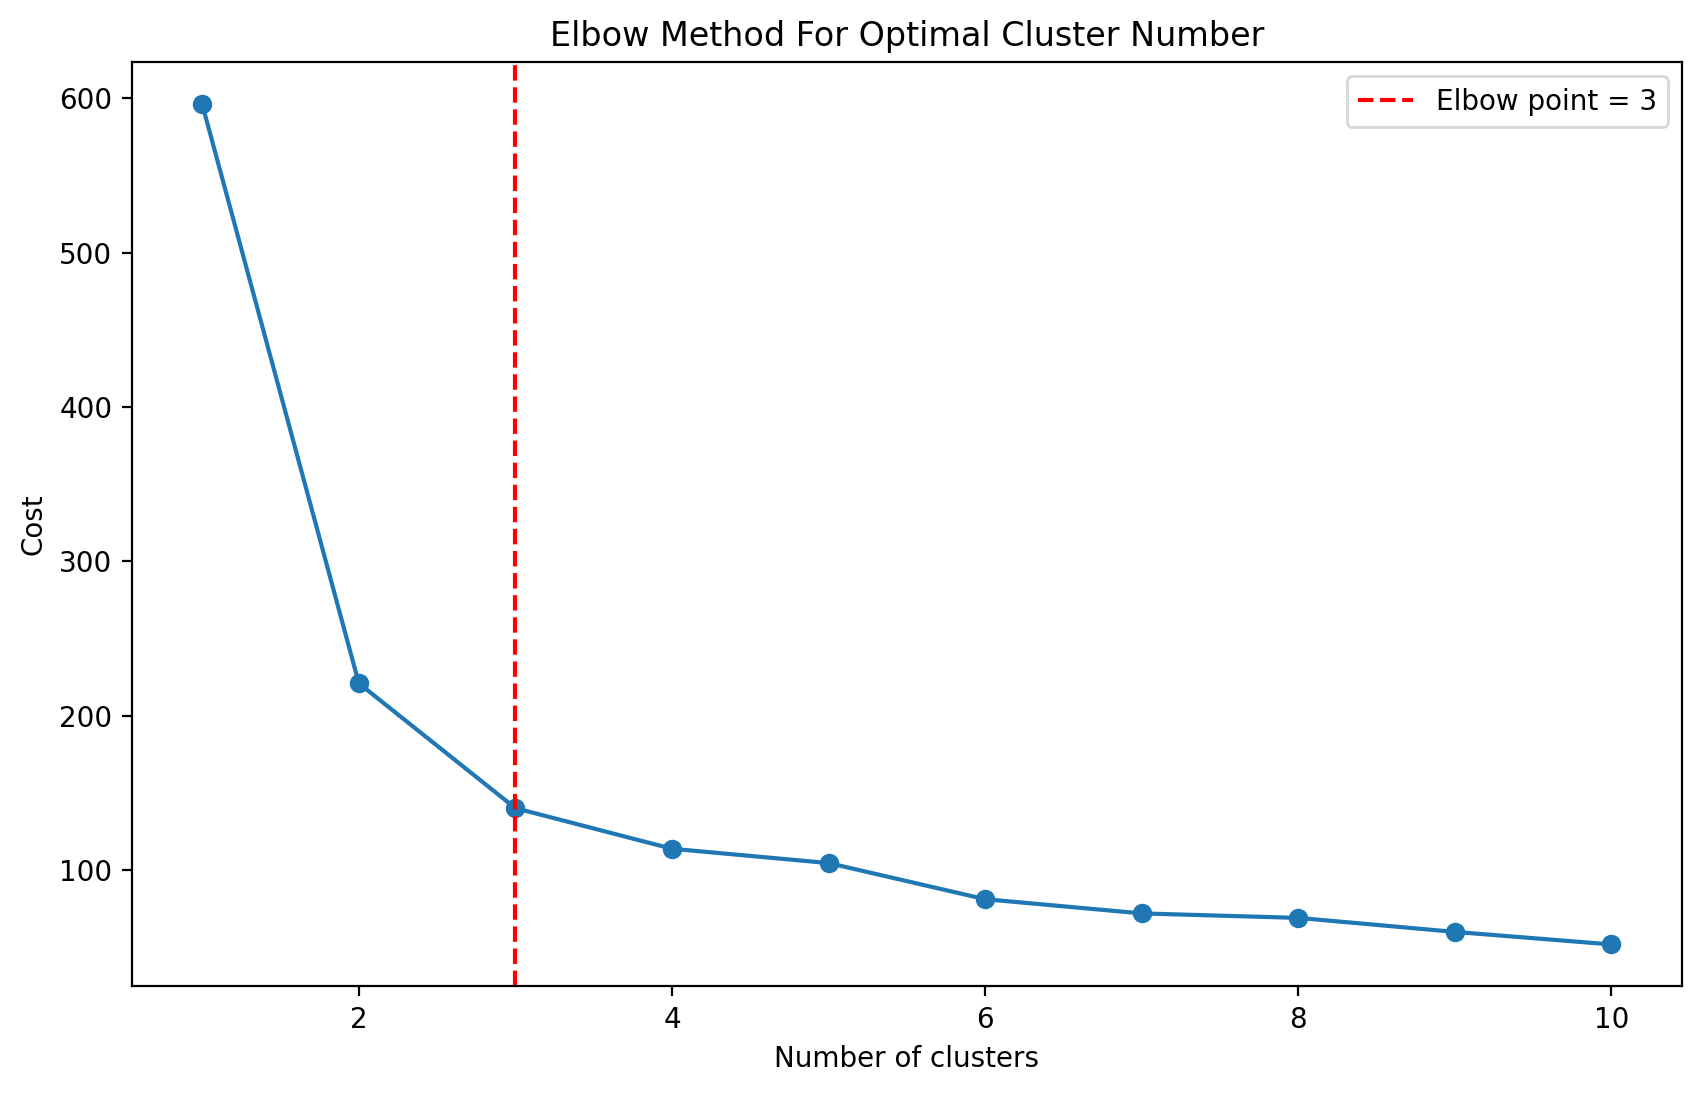

In [9]:
from estyp.cluster import NClusterSearch
from sklearn.cluster import KMeans

X = data.iloc[:, :-1].apply(lambda x: (x - x.mean()) / x.std())

searcher = NClusterSearch(
    estimator    = KMeans(n_init="auto"),
    method       = "elbow",
    random_state = 2023
)
searcher.fit(X)

print("- Clusters suggested: ", searcher.optimal_clusters_)
print("- Best estimator    : ", searcher.best_estimator_)
searcher.plot()

Normality tests results:
- Residuals appear as normally distributed according to KS test (p-value = 0.545).
- Residuals appear as normally distributed according to Shapiro-Wilk test (p-value = 0.088).
- Residuals don't appear as normally distributed according to Jarque-Bera test (p-value = 0.033).
- Residuals appear as normally distributed according to Omni test (p-value = 0.061).


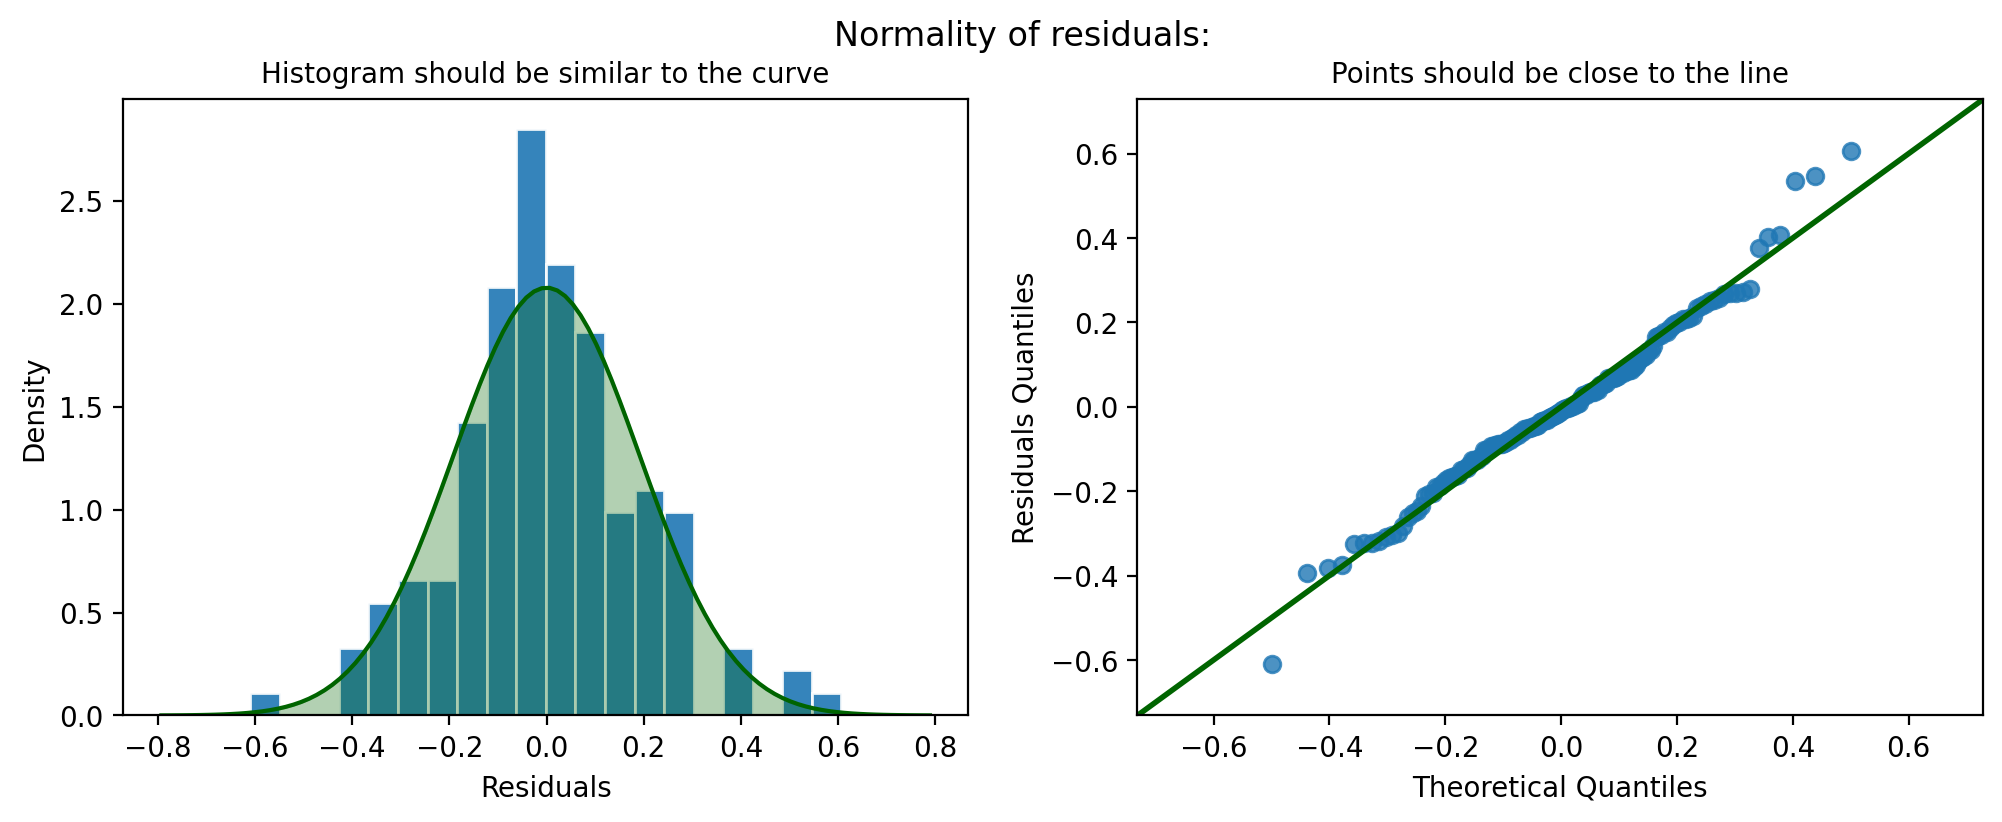

Homocedasticity tests results:
- Heteroscedasticity (non-constant error variance) detected according to Breusch-Pagan test (p-value = 0.000).
- Heteroscedasticity (non-constant error variance) detected according to White test (p-value = 0.004).
- Heteroscedasticity (non-constant error variance) detected according to Goldfeld-Quandt test (p-value = 0.000).


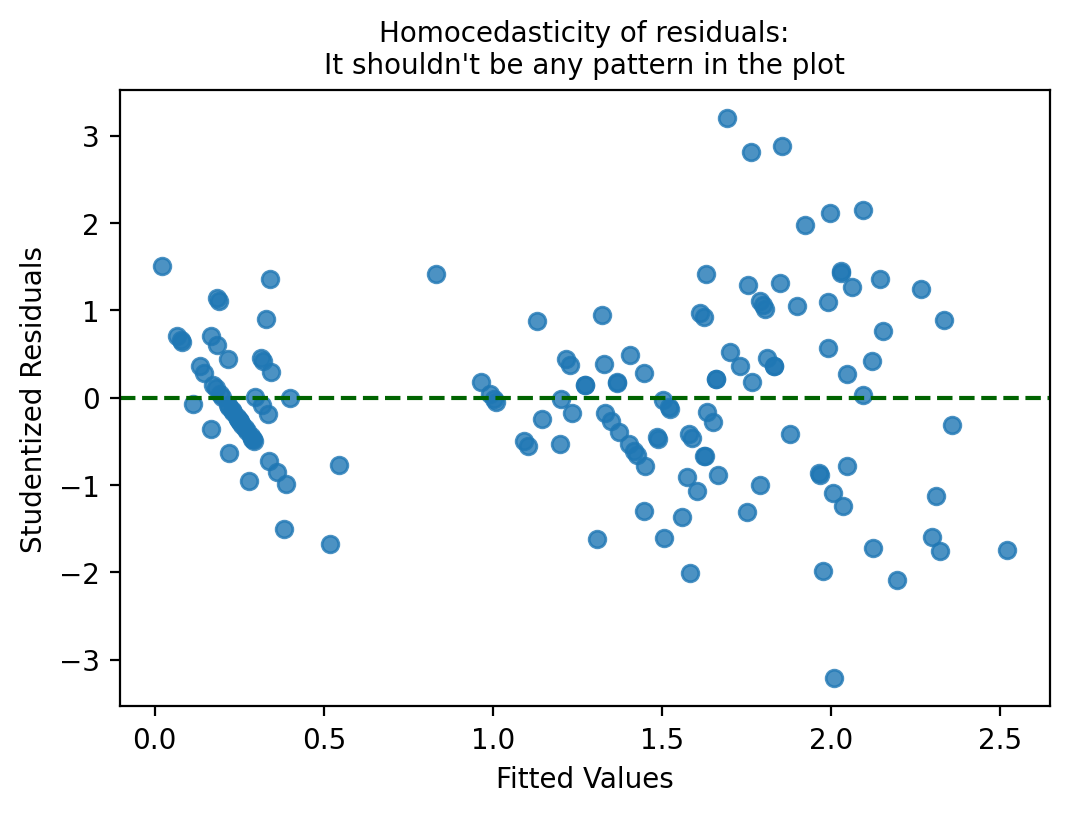

Independence tests results:
- Residuals appear to be independent and not autocorrelated according to DW test (DW-Statistic = 1.573)
- Autocorrelated residuals detected according to Box-Pierce test (p-value = 0.008).
- Autocorrelated residuals detected according to Breusch-Godfrey test (p-value = 0.038).


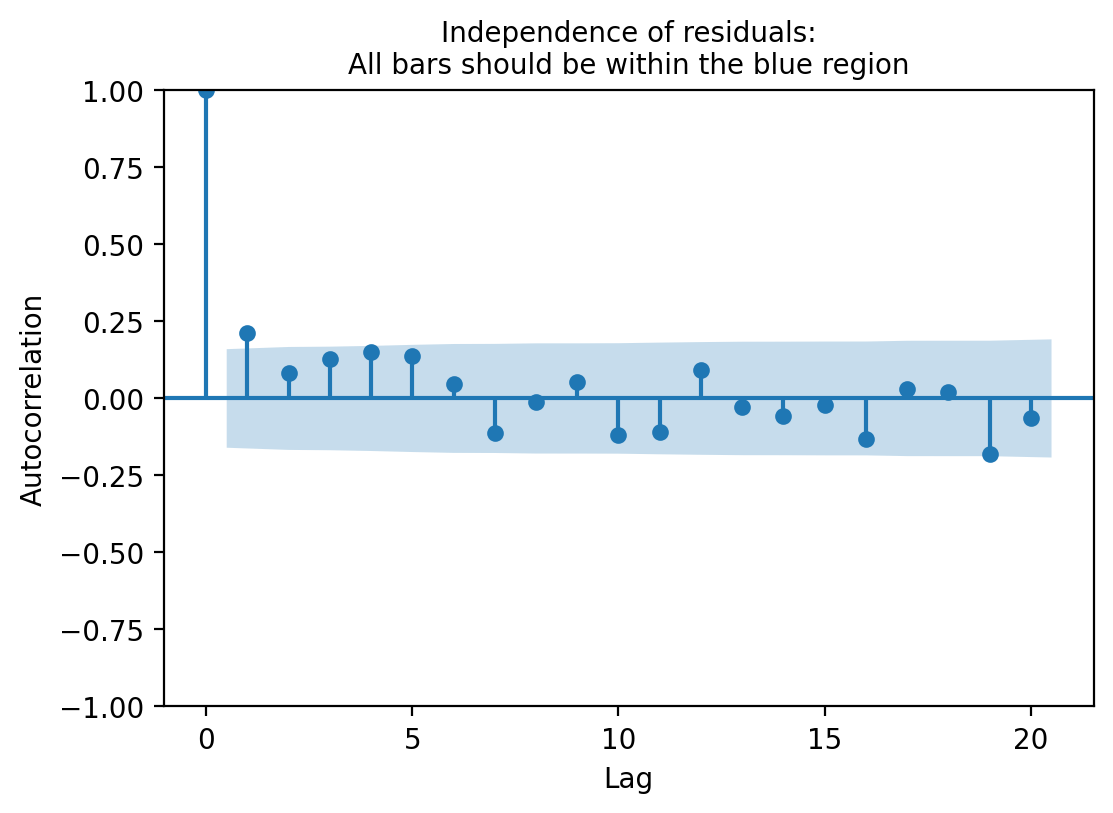

Multicollinearity test results:
- The model may have multicollinearity problems (condition number = 90.12).


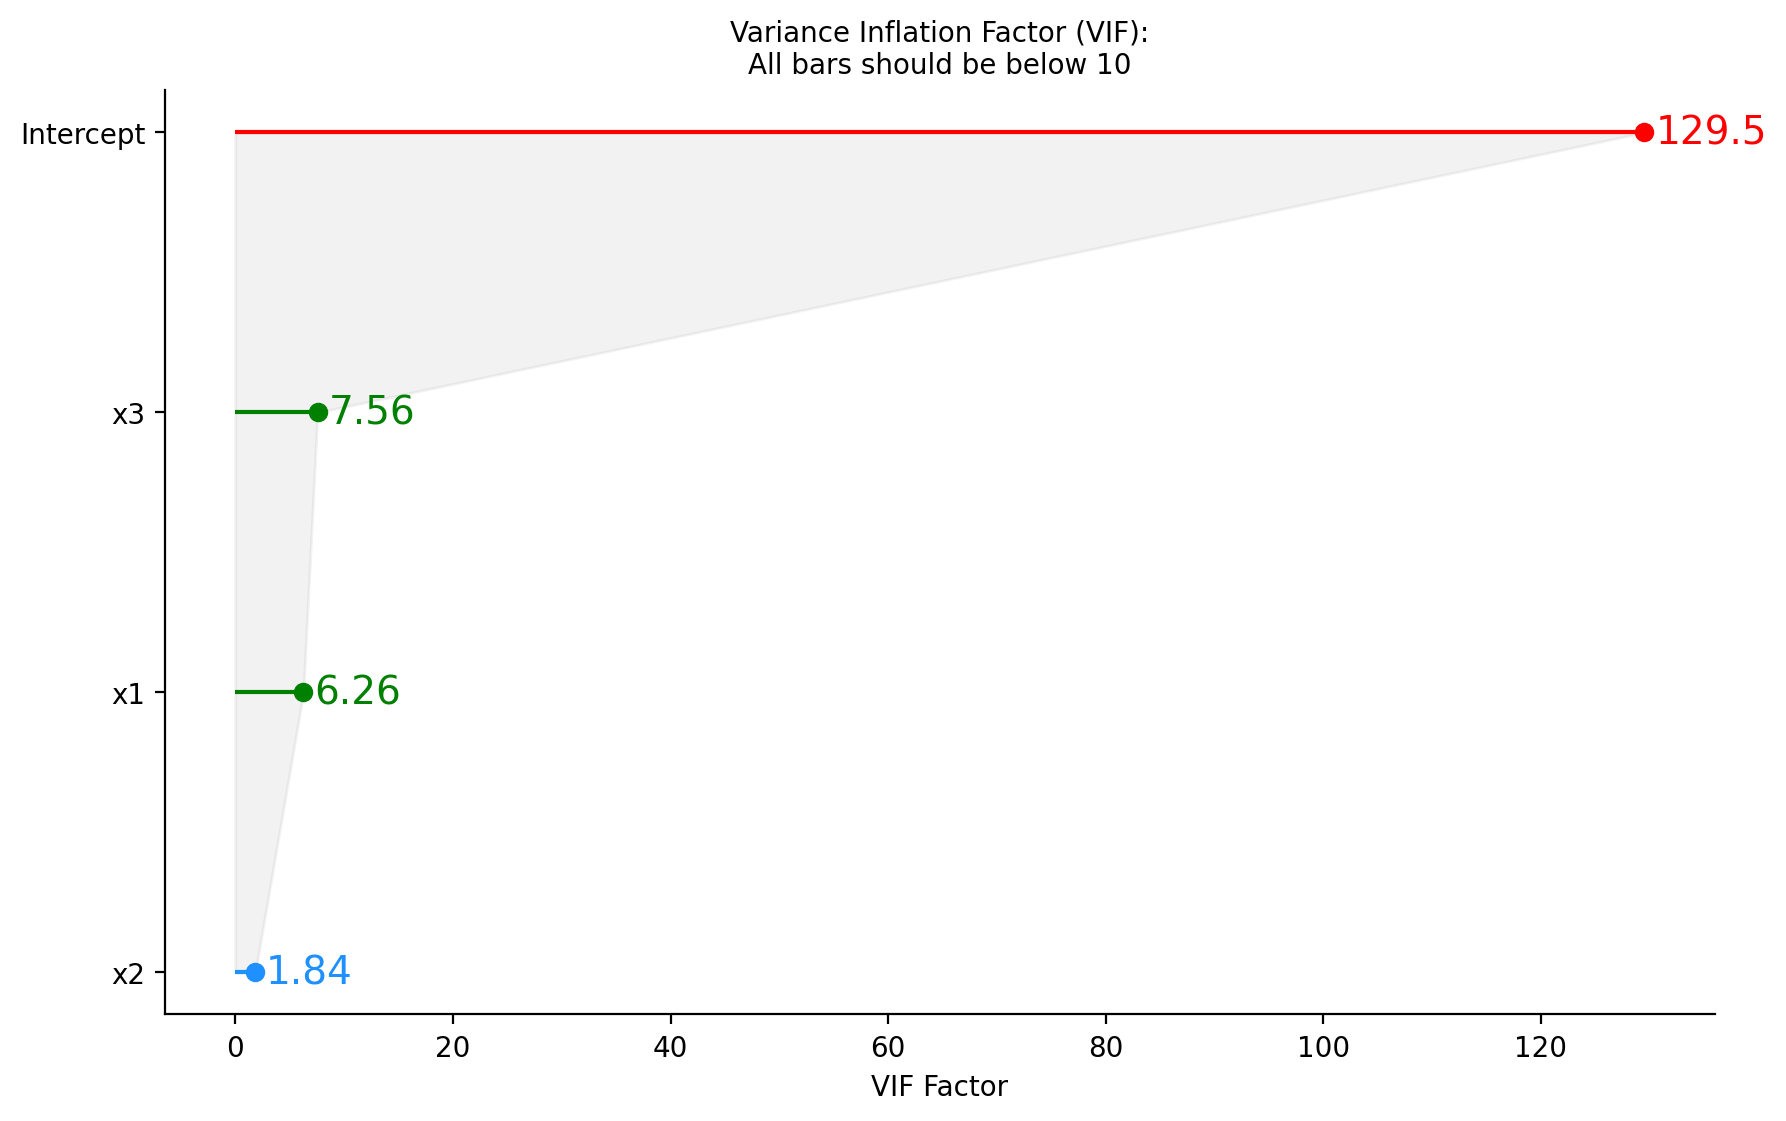

In [10]:
from estyp.testing import CheckModel
import statsmodels.api as sm

model = sm.OLS.from_formula('x4 ~ x1 + x2 + x3', data=data).fit()
checker = CheckModel(model)
checker.check_all()